# <center> Rendu 2 </center>
## <center> Philippa Payne </center>


---


## <center> Partie 1 : Pré-traitement et statistiques </center>


---


### 1.1 Veillez à ce que chaque document de votre corpus soit dans un fichier séparé, dans un même dossier.

Si une chronologie existe dans votre corpus, veillez à ce que chaque fichier soit nommé selon cet ordre.

In [113]:
import re
import os
import spacy
import collections
from tqdm import tqdm
import pandas as pd
import gensim
from gensim.models import TfidfModel, LdaModel, CoherenceModel, Word2Vec
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps
from sklearn.manifold import TSNE
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import textwrap
from transformers import BertModel, BertTokenizer

text_path = 'don_quixote.txt'

with open(text_path, encoding='utf-8') as file:
  lines = file.readlines()

volume_regex = r'.* VOLUME II.$'
chapter_regex = r'^CHAPTER [A-Z]+'
part_regex = r'.* PART I$'
newline_regex = r'^\n$'
image_regex = r'Full Size\n'
file_regex = r'.*\.jpg'
end_regex = r'.* END OF THE PROJECT GUTENBERG EBOOK DON QUIXOTE'
miscellaneous_regex = r'.*\([0-9]+K\)'

volume_1 = []
volume_2 = []

volume = None

for line in lines:
  if re.match(end_regex, line):
    break
  if re.match(part_regex, line):
    volume = 1
  elif re.match(volume_regex, line):
    volume = 2
  if volume == 1 and not re.match(newline_regex, line):
    volume_1.append(line)
  elif volume == 2 and not re.match(newline_regex, line):
    volume_2.append(line)

def separate_chapters(volume):
  chapters = []
  text = ''
  for line in volume:
    line = re.sub(image_regex, '', line)
    line = re.sub(file_regex, '', line)
    line = re.sub(miscellaneous_regex, '', line)
    if re.match(chapter_regex, line) or line == volume[-1]:
      chapters.append(text)
      text = ''
    if re.match(volume_regex, line) is None and re.match(chapter_regex, line) is None and re.match(part_regex, line) is None:
      text += line
  return chapters

volume_1 = separate_chapters(volume_1)
volume_2 = separate_chapters(volume_2)

chapters = 'by_chapter'

os.makedirs(chapters, exist_ok=True)

def create_files(volume):
  for i, text in enumerate(volume):
    with open(f'{chapters}/chapter_{i:02d}.txt', 'w', encoding='utf-8') as file:
      file.write(text)

create_files(volume_1)
create_files(volume_2)

### 1.2 En utilisant un modèle de langage Spacy construisez une fonction qui permette d’obtenir les statistiques sur un document.

In [114]:
nlp = spacy.load('en_core_web_sm')

path = 'by_chapter'

files = os.listdir(path)
files.sort()

def get_statistics(chapter):
  lemmas = []
  pos = []
  for token in chapter:
    if not (token.is_stop or token.is_punct or token.is_space):
      lemmas.append(token.lemma_.lower())
      pos.append(token.pos_)
  person = [entity.text for entity in chapter.ents if entity.label_=='PERSON']
  lemma_counts = collections.Counter(lemmas)
  pos_counts = collections.Counter(pos)
  person_counts = collections.Counter(person)
  statistics_dictionary = {'n_tokens': len(chapter), 'n_lemmas': len(lemmas), 'n_lemma_types': len(set(lemmas)), 'top_5_lemmas': { lemma: count for lemma, count in sorted(lemma_counts.items(), key=lambda item: item[1], reverse=True)[:6]}, 'pos_distribution': {pos: round(count/len(lemmas)*100, 2) for pos, count in sorted(pos_counts.items(), key=lambda item: item[1],reverse=True)}, 'top_5_people': {person: count for person, count in sorted(person_counts.items(), key=lambda item: item[1], reverse=True)[:6]}}
  return statistics_dictionary

### 1.3 Construisez une autre fonction qui effectue les pré-traitements suivants sur un document.

Cette fonction doit sauvegarder le résultat final dans un fichier, avec chaque phrase du document sur une ligne.

In [115]:
def preprocess_chapter(chapter, output):
  with open(output, 'w', encoding='utf-8') as file:
    for sent in chapter.sents:
      line = ''
      for token in sent:
        if not (token.is_stop or token.is_punct or token.is_space):
          line += f'{token.lemma_.lower()} '
      if re.sub(r'\s+', '', line) != '':
        file.write(line[:-1] + '\n')

### 1.4 Appliquez vos deux fonctions sur tout votre corpus, sauvez le corpus pré-traité dans un nouveau dossier, et interprétez brièvement les statistiques.

In [116]:
results = pd.DataFrame(None, columns=['n_tokens', 'n_lemmas', 'n_lemma_types', 'top_5_lemmas', 'pos_distribution', 'top_5_people'])

preprocessed = 'by_chapter_preprocessed'

os.makedirs(preprocessed, exist_ok=True)

for file in tqdm(files):
  file_path = f'{chapters}/{file}'
  with open(file_path, 'r', encoding='utf-8') as text_file:
    text = text_file.read()
  document = nlp(text)
  statistics_dictionary = get_statistics(document)
  row = pd.DataFrame.from_dict(statistics_dictionary, orient='index').T
  results = pd.concat([results, row], axis=0, ignore_index=True)
  preprocess_chapter(document, f"{preprocessed}/{file}")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

results

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:30<00:00,  2.46it/s]


,n_tokens,n_lemmas,n_lemma_types,top_5_lemmas,pos_distribution,top_5_people
0,2425,730,483,"{'dog': 12, 'don': 8, 'great': 8, 'excellency'...","{'NOUN': 41.78, 'VERB': 28.08, 'ADJ': 14.52, '...","{'Don Quixote': 3, 'Thou': 2, 'Don': 1, 'Majes..."
1,5549,1704,886,"{'don': 33, 'say': 33, 'quixote': 29, 'curate'...","{'NOUN': 42.37, 'VERB': 27.46, 'ADJ': 13.67, '...","{'Don Quixote': 22, 'Majesty': 6, 'Señor Don Q..."
2,2442,723,403,"{'sancho': 29, 'say': 28, 'don': 20, 'quixote'...","{'NOUN': 39.56, 'VERB': 30.29, 'PROPN': 16.74,...","{'Don Quixote': 16, 'Thou': 3, 'thou knowest':..."
3,3964,1154,607,"{'say': 46, 'sancho': 29, 'don': 25, 'quixote'...","{'NOUN': 41.59, 'VERB': 28.25, 'PROPN': 15.86,...","{'Don Quixote': 16, 'Señor Don': 2, 'Señor Don..."
4,2673,742,440,"{'say': 19, 'sancho': 18, 'don': 15, 'quixote'...","{'NOUN': 39.35, 'VERB': 29.78, 'PROPN': 15.9, ...","{'Don Quixote': 14, 'Señor Samson': 3, 'Don Qu..."
5,3400,929,497,"{'sancho': 27, 'say': 26, 'teresa': 20, 'gover...","{'NOUN': 41.66, 'VERB': 30.14, 'PROPN': 12.38,...","{'Teresa': 15, 'Don Quixote': 3, 'Mari-Sancha'..."
6,2783,816,509,"{'know': 17, 'great': 15, 'knight': 12, 'say':...","{'NOUN': 47.79, 'VERB': 25.98, 'ADJ': 15.44, '...","{'Don Quixote': 6, 'Majesty': 2, 'Teresa Casca..."
7,3617,1066,550,"{'sancho': 30, 'say': 26, 'don': 22, 'quixote'...","{'NOUN': 38.93, 'VERB': 31.61, 'PROPN': 13.23,...","{'Don Quixote': 18, 'Don': 2, 'sally': 1, 'Sam..."
8,3665,1158,653,"{'sancho': 30, 'say': 26, 'don': 21, 'quixote'...","{'NOUN': 43.01, 'VERB': 26.6, 'PROPN': 15.37, ...","{'Don Quixote': 16, 'DEL TOBOSO': 1, 'Hamete B..."
9,2000,616,311,"{'sancho': 26, 'say': 20, 'don': 15, 'quixote'...","{'NOUN': 42.21, 'VERB': 30.03, 'PROPN': 16.23,...","{'Don Quixote': 13, 'Don Quixote': 2, 'Thou': ..."


We can see that many of the top lemmas in each chapter refer to Don Quixote and Sancho Panza, the two main characters of the work. The number of tokens per chapter is quite even, although the number of lemmas fluctuates. Part-of-speech tagging demonstrates that nouns and verbs dominate the corpus, however, some chapters, most significantly the first two chapters, also contain a large amount of adjectives (in the first two chapters this result could demonstrate the author setting up the story in terms of characterization and world-building). We clearly see from the top people that Don Quixote is rightly the (eponymous!) protagonist of this work. Empirically, we notice that great, say, master, duchess, governor and knight are recurring top lemmas.


---


## <center> Partie 2 : AFC </center>


---


### 2.1 Construisez une table terme-document, puis filtrez les mots les moins et les plus fréquents.

In [117]:
files = os.listdir(preprocessed)
files.sort()

texts = []

for file in files:
  with open(f'{preprocessed}/{file}', encoding='utf-8') as text_file:
    texts.append(text_file.read().split())

dictionary = gensim.corpora.Dictionary(texts)

for key, id in dictionary.token2id.items():
  if id > 10:
    break

corpus = [dictionary.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

tfidf_df = pd.DataFrame()

for tfidf_doc in corpus_tfidf:
  top_couples = sorted(tfidf_doc, key=lambda item: item[1], reverse=True)[:10]
  top_words = [dictionary[id] for id, _ in top_couples]
  tfidf_df = pd.concat([tfidf_df, pd.Series(top_words)], axis=1, ignore_index=True)

term_document = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary))

def get_frequencies(corpus, dictionary):
  term_document = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary))
  frequencies = term_document.sum(axis=1)
  word_frequencies = [(word, frequencies[id]) for word, id in dictionary.token2id.items()]
  word_frequencies = sorted(word_frequencies, key=lambda item: item[1], reverse=True)
  return word_frequencies

word_frequencies = get_frequencies(corpus, dictionary)

minimum = 50
maximum = 1500

banned_word_ids = [dictionary.token2id[word] for word, frequency in word_frequencies if frequency < minimum or frequency > maximum]

dictionary.filter_tokens(bad_ids=banned_word_ids)

corpus = [dictionary.doc2bow(text) for text in texts]

### 2.2 Effectuez une AFC.

In [118]:
def sorted_eig(matrix, dim_max=None):
    if (dim_max is not None) and dim_max < matrix.shape[0] - 1:
        eigen_values, eigen_vectors = scipy.sparse.linalg.eigs(matrix, dim_max)
    else:
        eigen_values, eigen_vectors = scipy.linalg.eig(matrix)
    sorted_indices = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[sorted_indices]
    eigen_vectors = eigen_vectors[:, sorted_indices]
    return np.real(eigen_values), np.real(eigen_vectors)

def correspondence_analysis(contingency):
    contingency = np.array(contingency)
    n_row, n_col = contingency.shape
    dim_max = min(n_row, n_col) - 1
    total = np.sum(contingency)
    f_row = contingency.sum(axis=1)
    f_row = f_row / sum(f_row)
    f_col = contingency.sum(axis=0)
    f_col = f_col / sum(f_col)
    independency = np.outer(f_row, f_col) * total
    normalized_quotient = contingency / independency - 1
    b_mat = (normalized_quotient * f_col) @ normalized_quotient.T
    k_mat = np.outer(np.sqrt(f_row), np.sqrt(f_row)) * b_mat
    eig_val, eig_vec = sorted_eig(k_mat, dim_max)
    eig_val = np.abs(eig_val[:dim_max])
    eig_vec = eig_vec[:, :dim_max]
    row_coord = np.real(np.outer(1 / np.sqrt(f_row), np.sqrt(eig_val)) * eig_vec)
    col_coord = (normalized_quotient.T * f_row) @ row_coord / np.sqrt(eig_val)
    row_contrib = eig_vec ** 2
    col_contrib = np.outer(f_col, 1 / eig_val) * col_coord ** 2
    row_cos2 = row_coord ** 2
    row_cos2 = (row_cos2.T / row_cos2.sum(axis=1)).T
    col_cos2 = col_coord ** 2
    col_cos2 = (col_cos2.T / col_cos2.sum(axis=1)).T
    return dim_max, eig_val, row_coord, col_coord, row_contrib, col_contrib, row_cos2, col_cos2

term_document = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary))

dim_max, eig_val, row_coord, col_coord, row_contrib, col_contrib, row_cos2, col_cos2 = correspondence_analysis(term_document)

### 2.3 Pour les 10 premiers axes, donnez le pourcentage d’inertie représentée et les 10 mots qui y contribuent le plus.

Interprétez brièvement.

In [119]:
n_top = 10

for dim in range(10):
  p_var = eig_val[dim] / sum(eig_val)
  top_contrib_ids = np.argsort(row_contrib[:, dim])[::-1][:n_top]
  contrib_dic = {dictionary[id]: round(row_contrib[id, dim]*100, 2) for id in top_contrib_ids if dictionary[id] != 'work'}
  print(f'Axe {dim} ({p_var:.2%}): {contrib_dic}')

Axe 0 (6.53%): {'teresa': 14.4, 'page': 7.56, 'governor': 7.03, 'letter': 6.03, 'government': 4.24, 'duchess': 3.7, 'daughter': 3.14, 'panza': 2.78, 'quixote': 2.76, 'husband': 2.46}
Axe 1 (5.79%): {'basilio': 9.06, 'thou': 9.05, 'thy': 7.6, 'thee': 5.47, 'samson': 4.88, 'bachelor': 4.59, 'history': 3.74, 'carrasco': 2.98, 'knight': 2.24, 'thyself': 1.91}
Axe 2 (5.14%): {'duenna': 13.67, 'duchess': 9.89, 'duke': 5.53, 'antonio': 4.84, 'señora': 2.9, 'lady': 2.64, 'thou': 2.38, 'doña': 2.35, 'governor': 2.32, 'island': 2.02}
Axe 3 (4.47%): {'pedro': 13.38, 'samson': 6.07, 'bachelor': 5.58, 'antonio': 5.45, 'carrasco': 4.08, 'thou': 3.76, 'sancho': 2.91, 'history': 2.55, 'proverb': 2.29, 'curate': 2.15}
Axe 4 (4.17%): {'antonio': 24.39, 'basilio': 13.2, 'grove': 2.94, 'book': 2.72, 'head': 2.43, 'pedro': 2.38, 'duchess': 1.99, 'thy': 1.88, 'thee': 1.79, 'duke': 1.58}
Axe 5 (4.00%): {'basilio': 27.79, 'antonio': 6.73, 'pedro': 4.43, 'sancho': 3.64, 'governor': 2.25, 'master': 2.03, 'husba

Most of the axes include several character names, alongside titles, settings and concepts that help us understand the status of each character, as well as the locations and themes most associated with them (Pedro -> Governor -> Island (Pedro is the servant of Sancho when he becomes governor of an island; thus this axis represents one storyline)).

### 2.4 Tracez le biplot avec les 100 termes les plus fréquents.

Interprétez brièvement.

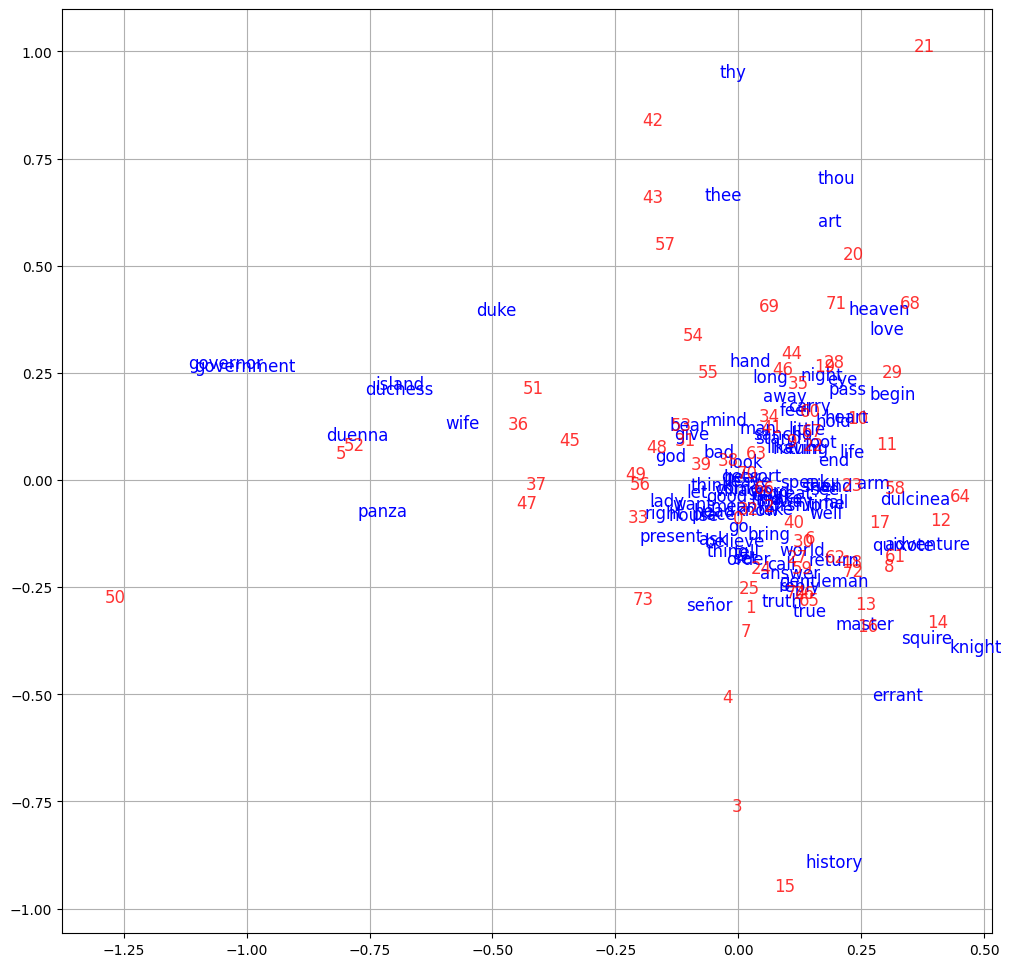

In [120]:
axes = [0, 1]

plt.rcParams['figure.figsize'] = [12, 12]

top_n = 100

word_frequencies = get_frequencies(corpus, dictionary)

top_words = [word for word, _ in word_frequencies[:top_n]]
top_word_ids = [dictionary.token2id[word] for word in top_words]
top_row_coord = row_coord[top_word_ids, :]

all_coord = np.concatenate([top_row_coord, col_coord])

fig, ax = plt.subplots()

ax.scatter(all_coord[:, axes[0]], all_coord[:, axes[1]], alpha=0, color="white")

for i, txt in enumerate(top_words):
    ax.annotate(txt, (top_row_coord[i, axes[0]], top_row_coord[i, axes[1]]), size=12, color="blue")

for i, txt in enumerate(range(len(corpus))):
    ax.annotate(txt, (col_coord[i, axes[0]], col_coord[i, axes[1]]), size=12, color="red", alpha=0.8)

ax.grid()

plt.show()

Empirically speaking some co-occurrences represented in the biplot seem reasonable, particularly in terms of the plot:
- Government/governor
- Duchess/duke/wife
- Island/Panza (Sancho becomes governor of an island in the course of the narrative)
- Errant/Quixote
- Dulcinea/love (Quixote represents a peasant woman as Dulcinea, the object of his affections/love)
- End/life
- Set/right
- Truth/true
- Master/squire/knight

Others demonstrate tokens that are likely to appear at the same time (in dialogue), although aren't as self-evident:
- Foot, night, well
- Get, thy, tell
- Hear, look, go


---


## <center> Partie 3 : Topic Modeling </center>


---


### 3.1 En utilisant le mesure de cohérence 𝐶𝑣, trouvez le nombre de thèmes idéal 𝑘 pour un modèle d’allocation de Dirichlet latente sur votre corpus.

Entrainez le modèle avec l’hyperparamètre trouvé.

In [121]:
ks = list(range(4, 21))

n_tests = 3

coherence_list = []

for k in tqdm(ks):
  sum_coherence = 0
  for _ in range(n_tests):
    lda_model = LdaModel(corpus, id2word=dictionary, num_topics=k, passes=10)
    sum_coherence += CoherenceModel(lda_model, texts=texts, dictionary=dictionary).get_coherence()
  coherence_list.append(sum_coherence / n_tests)

100%|██████████| 17/17 [04:20<00:00, 15.32s/it]


### 3.2 Affichez la répartition des 10 mots les plus probables pour chaque thème.

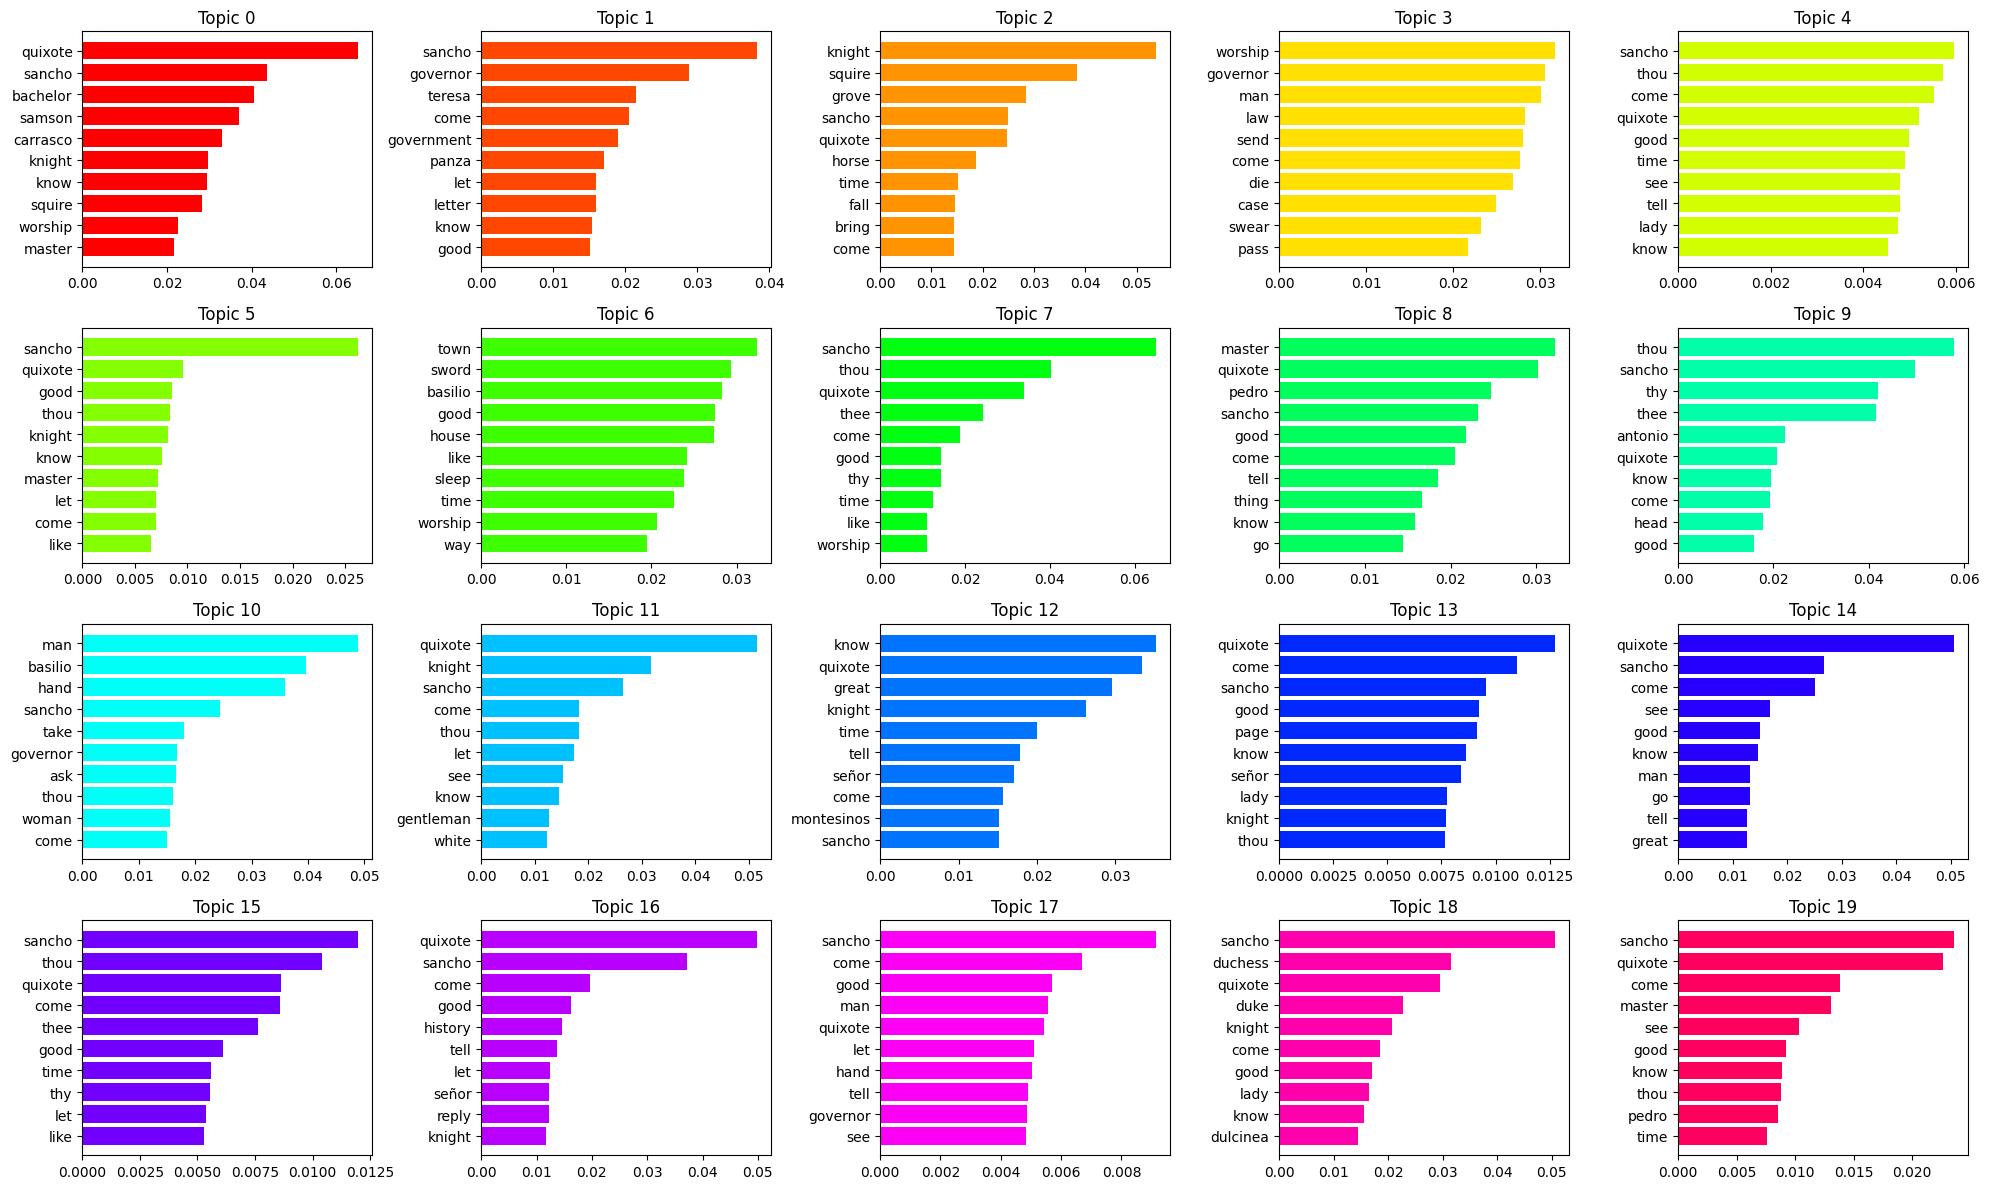

In [122]:
topic_color = colormaps['hsv'](np.linspace(0.0, 1.0, lda_model.num_topics + 1))

nx_grid = int(np.sqrt(lda_model.num_topics))
ny_grid= int(np.ceil(lda_model.num_topics / nx_grid))

plt.rcParams['figure.figsize'] = [ny_grid*4, nx_grid*3]

fig = plt.figure()

grid_layout = GridSpec(nx_grid, ny_grid)

for i in range(lda_model.num_topics):
  top_words = lda_model.show_topic(i, topn=10)
  words = [word for word, _ in top_words]
  frequencies = [frequency for _, frequency in top_words]
  ax = fig.add_subplot(grid_layout[i])
  ax.barh(words, frequencies, color=topic_color[i])
  ax.set_title(f'Topic {i}')
  ax.invert_yaxis()

grid_layout.tight_layout(fig)

### 3.3 Affichez la répartition des thèmes dans les documents.

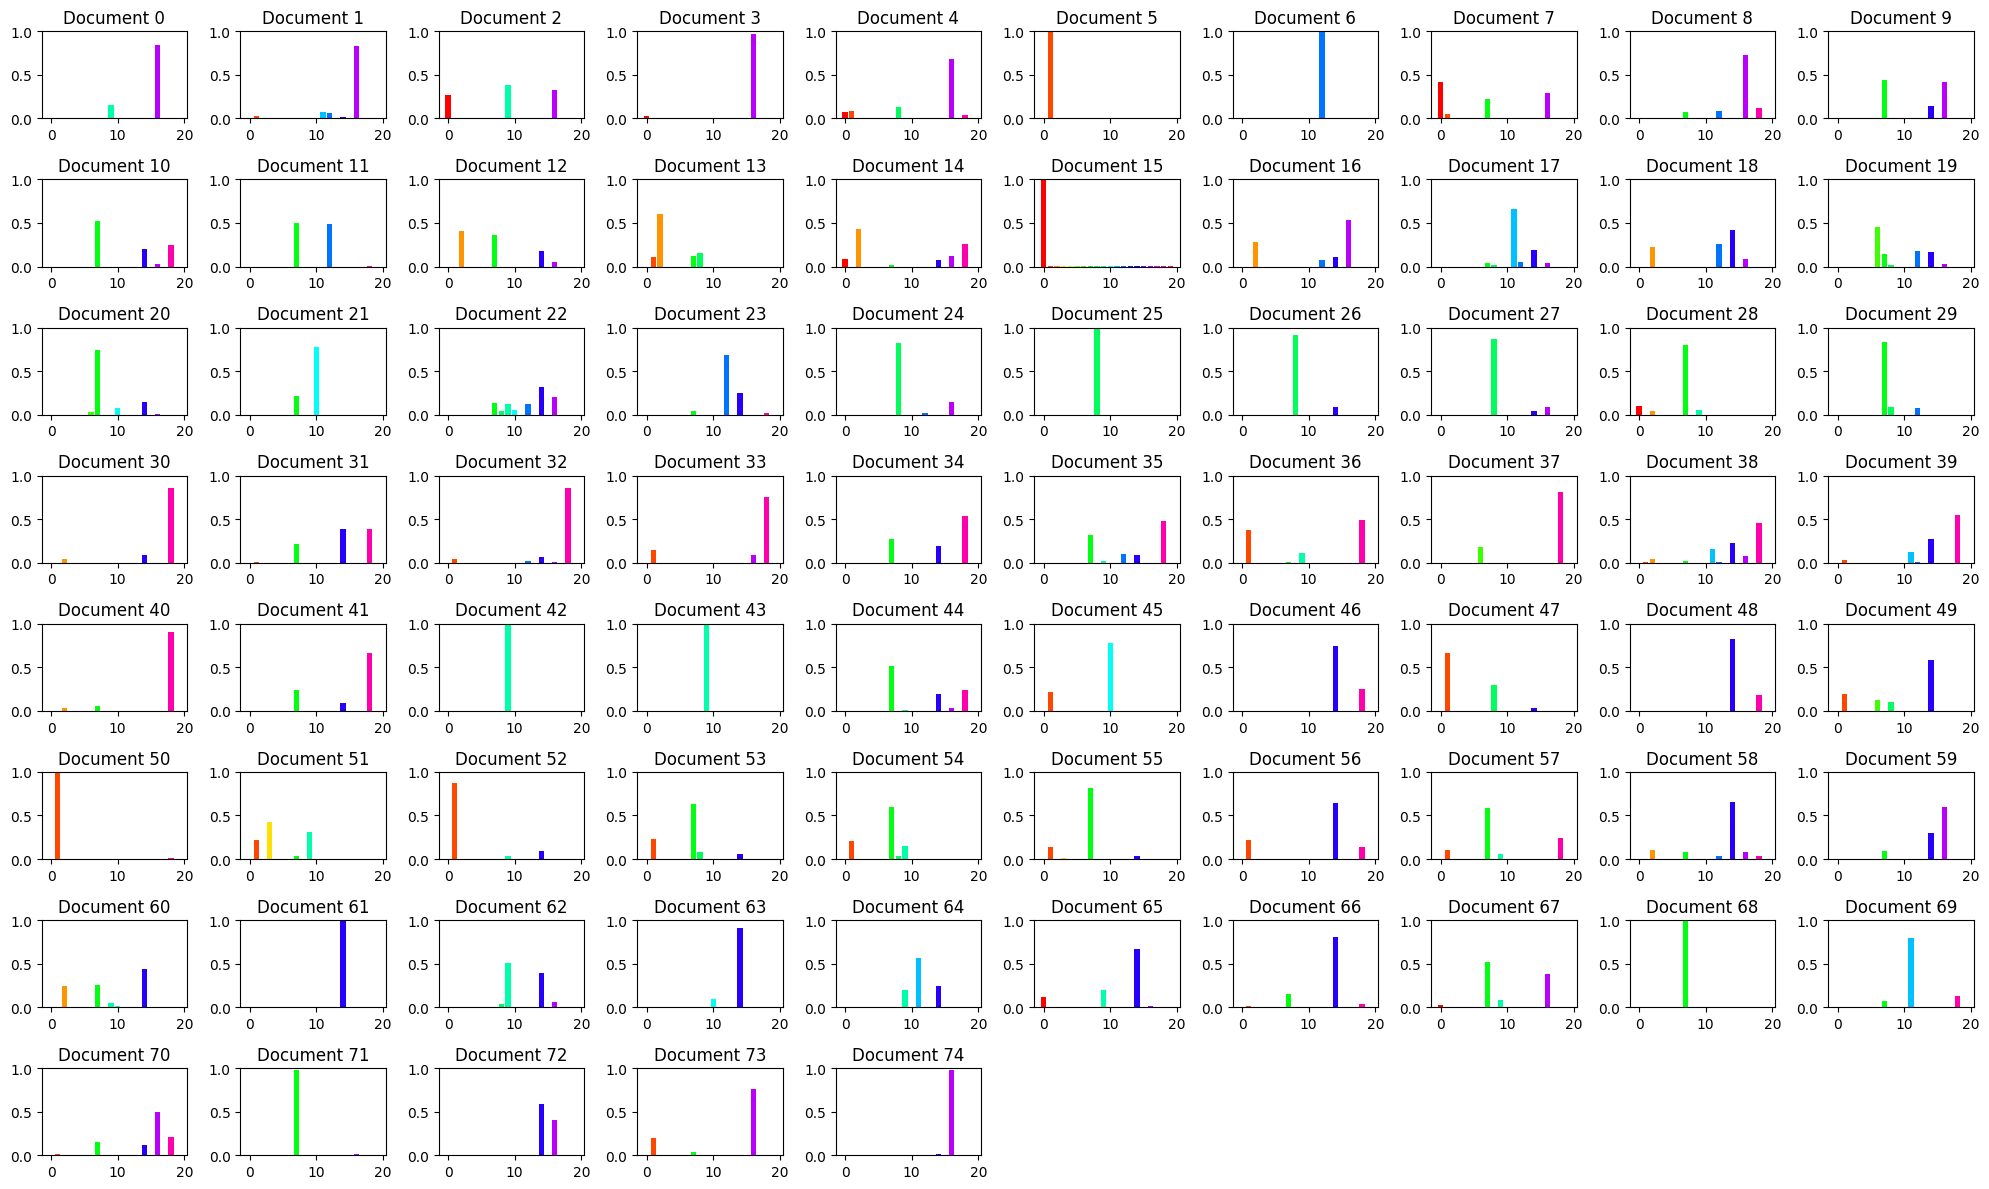

In [123]:
nx_grid = int(np.sqrt(len(corpus)))
ny_grid= int(np.ceil(len(corpus) / nx_grid))

plt.rcParams['figure.figsize'] = [ny_grid*2, nx_grid*1.5]

fig = plt.figure()

grid_layout = GridSpec(nx_grid, ny_grid)

for i, document in enumerate(corpus):
  topics_frequencies = lda_model.get_document_topics(document, minimum_probability=0)
  topics = [topic for topic, _ in topics_frequencies]
  frequencies = [frequency for _, frequency in topics_frequencies]
  ax = fig.add_subplot(grid_layout[i])
  ax.bar(topics, frequencies, color=topic_color)
  ax.set_title(f'Document {i}')
  ax.set_ylim([0, 1])

grid_layout.tight_layout(fig)

### 3.4 Interprétez 3.2 et 3.3 ensemble.

The topic analysis of Don Quixote is rather unconvincing. There is a lot of redundancy between topics (Sancho, Quixote, come, know, good, and see are present in several of the topics shown in 3.2). The creation of topics is more successful in highlighting particular events in the work involving specific characters, as with the following topics:

- Montesinos - episode in the cave of Montesinos
- Pedro - servant of Sancho
- Dulcinea - fake designation for love interest of Don Quixote
- Antonio/Carrasco - both remark on Quixote's madness
- Samson - friend that aims to send Quixote home
- Teresa/Sancho (governor/lady/page/island) - wife of Sancho who becomes governor of island
- Antonio (book) - incident with book at Antonio's house
- Altisidora (love/marry/good) -  lady in waiting who mocks Quixote by pretending to be romantically interested in him

By tracing these topics and the documents to which they belong, we can find the relevant episodes/character appearances in the course of the work, however, these topics do not offer us anything very fruitful in terms of literary themes or abstract concepts that add to our understanding of the work as a piece of literature. Other topics tend to represent chapters with much dialogue between Quixote and Sancho, hence the prevalence of their names, certain common verbs, and words such as 'thee', 'thy' and 'thou'.

However, one particular topic that did come out from this analysis involved 'arm', 'enemy', 'life', 'fall', 'god' and 'lose' which could well be interpreted as referring to a topic related to combat; this topic successfully captured a key theme in the narrative.


---


## <center> Partie 4 : Word Embeddings </center>


---


### 4.1 Appliquez la méthode Word2Vec sur votre corpus avec une fenêtre de 5 mots et des vecteurs de taille 300, tout en filtrant les mots les moins fréquents afin d’avoir un vocabulaire de taille raisonnable.

In [124]:
files = os.listdir(preprocessed)

sentences = []

for file in files:
  with open(f'{preprocessed}/{file}', encoding='utf-8') as text_file:
    text_sentences = text_file.readlines()
    text_token_sentences = [text_sentence.split() for text_sentence in text_sentences]
    sentences.extend(text_token_sentences)

wv_model = Word2Vec(sentences, min_count=100, window=5, vector_size=300, sg=1)
wv_vocabulary = wv_model.wv.key_to_index
wv_words = list(wv_vocabulary.keys())

### 4.2 Choisissez trois termes, et affichez les 10 mots les plus proches de ces trois termes.

Interprétez brièvement.

In [125]:
wv_model.wv.most_similar('quixote')

[('la', 0.9947506785392761),
 ('adventure', 0.9939563870429993),
 ('call', 0.9927816390991211),
 ('duke', 0.992772102355957),
 ('history', 0.992737889289856),
 ('having', 0.9924724102020264),
 ('gentleman', 0.9922711253166199),
 ('ask', 0.9920249581336975),
 ('order', 0.991856038570404),
 ('return', 0.9917843341827393)]

In [126]:
wv_model.wv.most_similar('sancho')

[('god', 0.9975184202194214),
 ('good', 0.9974812865257263),
 ('bad', 0.9974700212478638),
 ('tell', 0.9973847270011902),
 ('government', 0.9973223805427551),
 ('go', 0.9971632361412048),
 ('bear', 0.9971145391464233),
 ('word', 0.9971002340316772),
 ('want', 0.9970786571502686),
 ('make', 0.9969725608825684)]

In [127]:
wv_model.wv.most_similar('duchess')

[('duke', 0.9975402355194092),
 ('having', 0.9972791075706482),
 ('señor', 0.996554970741272),
 ('history', 0.9961743950843811),
 ('adventure', 0.9954776763916016),
 ('duenna', 0.9953858852386475),
 ('order', 0.9953168034553528),
 ('day', 0.9949804544448853),
 ('take', 0.994913637638092),
 ('worship', 0.9948260188102722)]

Since the textual analysis has brought out the strength of character associations above other topics/themes, I have chosen to analyze the terms closest to 3 key characters in the text:
- Quixote: Don Quixote is often referred to in other contexts as 'gentleman', 'knight', 'duke' and 'señor', ways of referring to his nobility other than 'don'. 'History' could be associated with Quixote as the work recounts his tale, whilst 'doubt' could refer to the way that the tale and other characters within it mock (put into doubt) his adventures.
- Sancho: there is a lot of dialogue within the work between Don Quixote and Sancho Panza which is reflected in these terms; 'ask', 'answer', 'believe', 'think' and 'know' reflect these conversations. 'Friend' reflects the relationship between Sancho and Quixote. 'Go' and 'carry' could also reflect Sancho's role in Quixote's adventures.
- Duchess: 'duenna', 'duke' and 'bachelor' refer to characters within the work; 'order' might give an indication of the duchess' personality and status within the narrative; 'Dapple' is the name of Sancho Panza's donkey and thus suggests scenes in which these two characters interact; 'señor' also demonstrates that the duchess addresses other characters in the narrative in a respectful fashion befitting her status.

### 4.3 Gardez les 100 mots les plus fréquents, puis projetez vos coordonnées Word2Vec dans un espace à 2 dimensions avec tSNE.

In [128]:
n_top_words = 100

word_frequency = [(word, wv_model.wv.get_vecattr(wv_vocabulary[word], 'count')) for word in wv_words]
word_frequency = sorted(word_frequency, key=lambda item: item[1], reverse=True)

top_words = word_frequency[:n_top_words]

top_vectors = np.empty((len(top_words), 300), dtype='f')

for i, (word, _) in enumerate(top_words):
  top_vectors[i] = wv_model.wv.get_vector(word)

coords_2d = TSNE(n_components=2, perplexity=5, init='pca', learning_rate='auto').fit_transform(top_vectors)

### 4.4 Affichez les coordonnées tSNE dans un graphique.

Interprétez brièvement.

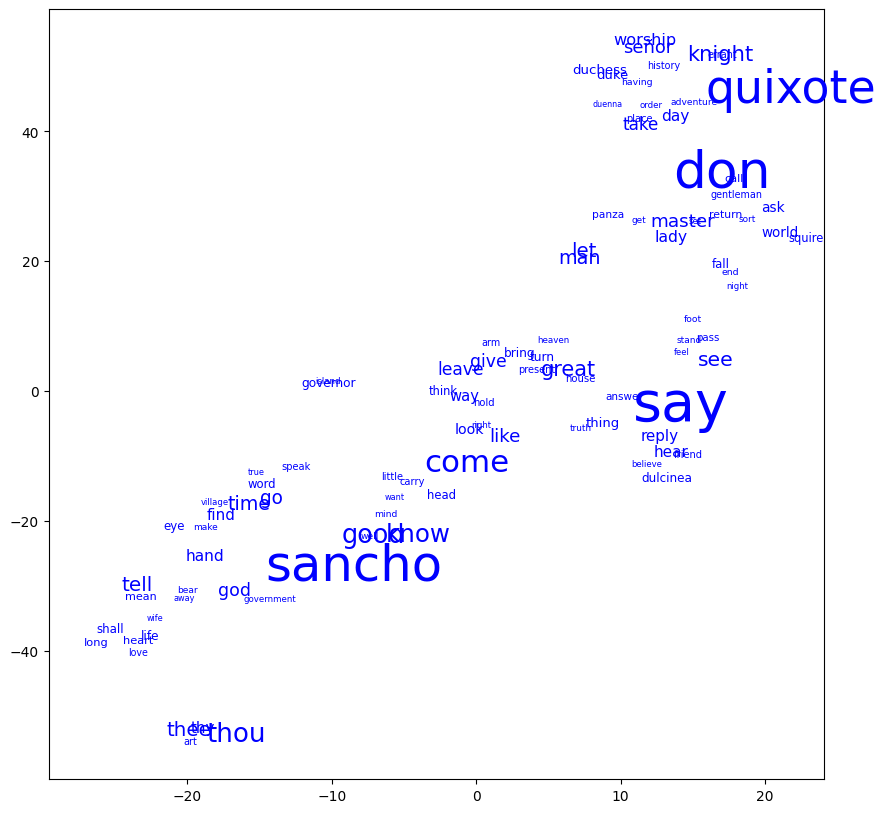

In [129]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.scatter(coords_2d[:,0], coords_2d[:,1], alpha=0)

for word, x, y in zip(top_words, coords_2d[:,0], coords_2d[:,1]):
    plt.annotate(word[0], xy=(x, y), xytext=(0, 0), textcoords='offset points', size=(word[1]/top_words[0][1])**(0.7)*40, color='blue')

plt.show()

It is clear from the beginning that this work is Don Quixote and tells the tale of Don Quixote and Sancho, recounting dialogues between them:

- Don + Quixote + Sancho + say

There are some particular relationships that stand out empirically:
- good + god - as in 'Good God!' to evoke surprise
- thy + thee + thou - similar archaisms used in dialogue
- government + island + governor - Sancho becomes the governor of an island
- señor + knight + errant - Don Quixote has the delusion that he is an errant knight
- duke + duchess - a couple in the work
- day + night - juxtapose each other naturally
- speak + truth + know - one of the themes of the work is knowing and speaking the truth; Don Quixote is deluded into believing he is an adventuring knight
- friend + Sancho - Don Quixote perceives Sancho as his friend
- gentleman + Quixote + master - Quixote is a gentleman and the master of Sancho
- love + heart - a natural association
- hand + eye + carry - 'heart' is also close to these three terms; three physical, bodily designations; it is natural for the hand to 'carry'
- long + away - determining distance
- hear + see + say - three very common verbs


---


## <center> Partie 5 : Génération de séquences avec LSTM </center>


---


### 5.1 Avec Pytorch, construisez une classe Dataset qui met en mémoire un document de votre corpus, et qui donne des couples entrée-sortie de type : séquence de 𝑘 tokens - séquence de 𝑘 tokens décalée d’un token sur la droite.

In [130]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SentenceData(Dataset):
    def __init__(self, file_path, nlp, seq_len):
        self.file_path = file_path
        self.seq_len = seq_len
        with open(self.file_path, 'r', encoding='utf-8') as file:
          text = file.read()
        document = nlp(text)
        self.tokens = [token.text for token in document if not token.is_space]
        self.dictionary = list(set(self.tokens))
        self.id2token = {id: token for id, token in enumerate(self.dictionary)}
        self.token2id = {token: id for id, token in enumerate(self.dictionary)}
        self.token_ids = [self.token2id[w] for w in self.tokens]
    def __len__(self):
        return len(self.token_ids) - self.seq_len
    def __getitem__(self, id):
        return (torch.tensor(self.token_ids[id:id+self.seq_len]),
                torch.tensor(self.token_ids[id+1:id+self.seq_len+1]))

### 5.2 Construisez 3 objets Datasets pour 3 documents tirés de votre corpus, avec longueur de séquence 𝑘 à choix. Construisez les DataLoaders correspondants, avec batch de 128.

In [131]:
documents = [f'{path}/chapter_06.txt', f'{path}/chapter_06.txt', f'{path}/chapter_06.txt']

examples = []
dataloaders = []

for document in documents:
  data = SentenceData(document, nlp, 10)
  examples.append(data)

batch_size = 128

for example in examples:
  data = DataLoader(example, batch_size=batch_size)
  dataloaders.append(data)

### 5.3 Avec le paramètre 𝑛words qui représente la taille du vocabulaire, construisez le modèle LSTM suivant.

Le retour sera les logodds des mots pour la séquence décalée de 1. N’oubliez pas de gérer les états internes du LSTM, en construisant une méthode qui met ces états à zéro.

In [132]:
class SeqGen(nn.Module):
    def __init__(self, n_vocab, embedding_dim, hidden_size, num_layers):
        super(SeqGen, self).__init__()
        self.n_vocab = n_vocab
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=self.n_vocab, embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, dropout=0.2, batch_first=True)
        self.lin_layer = nn.Linear(self.hidden_size, self.n_vocab)
    def forward(self, x, prev_state=None):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logodds = self.lin_layer(output)
        return logodds, state

### 5.4 Créez 3 modèles et entrainez chacun d’entre eux sur un document différent parmi les documents que vous avez sélectionnés dans la partie [5.3].

In [134]:
generations = []
optimizers = []

loss_function = nn.CrossEntropyLoss()

n_epochs = 30

for example in examples:
  data = SeqGen(len(example.dictionary), 128, 128, 3)
  generations.append(data)

for generation in generations:
  data = torch.optim.Adam(generation.parameters(), lr=0.001)
  optimizers.append(data)

for i, (generation, dataloader) in enumerate(zip(generations, dataloaders)):
  generation.to(device)
  generation.train()
  for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}', end=': ')
    sum_loss = 0
    for input, output in dataloader:
      input = input.to(device)
      output = output.to(device)
      optimizers[i].zero_grad()
      pred, _ = generation(input)
      loss = loss_function(pred.transpose(1, 2), output)
      loss.backward()
      optimizers[i].step()
      sum_loss += loss.item()
    print(f'mean loss = {sum_loss / len(dataloader):.4f}')

Epoch 1: mean loss = 6.4780
Epoch 2: mean loss = 5.7506
Epoch 3: mean loss = 5.5939
Epoch 4: mean loss = 5.5592
Epoch 5: mean loss = 5.5398
Epoch 6: mean loss = 5.5269
Epoch 7: mean loss = 5.5162
Epoch 8: mean loss = 5.5071
Epoch 9: mean loss = 5.4963
Epoch 10: mean loss = 5.4782
Epoch 11: mean loss = 5.4445
Epoch 12: mean loss = 5.3966
Epoch 13: mean loss = 5.3358
Epoch 14: mean loss = 5.2654
Epoch 15: mean loss = 5.1933
Epoch 16: mean loss = 5.1323
Epoch 17: mean loss = 5.0915
Epoch 18: mean loss = 5.0487
Epoch 19: mean loss = 5.0152
Epoch 20: mean loss = 4.9524
Epoch 21: mean loss = 4.9033
Epoch 22: mean loss = 4.8629
Epoch 23: mean loss = 4.8168
Epoch 24: mean loss = 4.7597
Epoch 25: mean loss = 4.7047
Epoch 26: mean loss = 4.6527
Epoch 27: mean loss = 4.6028
Epoch 28: mean loss = 4.5586
Epoch 29: mean loss = 4.5189
Epoch 30: mean loss = 4.4850
Epoch 1: mean loss = 6.4827
Epoch 2: mean loss = 5.7629
Epoch 3: mean loss = 5.5918
Epoch 4: mean loss = 5.5555
Epoch 5: mean loss = 5.5353

### 5.5 Générez 3 textes aléatoires de taille 200 avec chacun des modèles.

Pouvez-vous identifier des séquences caractéristiques de vos documents ?

In [136]:
input_sentence = 'The knight was'

n_generated_tokens = 200

output_tokens = input_sentence.split()

generations[0].eval()

input = torch.tensor([examples[0].token2id[token] for token in output_tokens]).to(device)

prediction, hidden = generations[0](input)

new_token_logodds = prediction.detach().cpu()[-1]

probabilities = torch.nn.functional.softmax(new_token_logodds, dim=0).numpy()

token_index = np.random.choice(len(new_token_logodds), p=probabilities)

output_tokens.append(examples[0].id2token[token_index])

for i in range(n_generated_tokens - 1):
  input = torch.tensor([examples[0].token2id[output_tokens[-1]]]).to(device)
  prediction, hidden = generations[0](input, hidden)
  new_token_logodds = prediction.detach().cpu().flatten()
  probabilities = torch.nn.functional.softmax(new_token_logodds, dim=0).numpy()
  token_index = np.random.choice(len(new_token_logodds), p=probabilities)
  output_tokens.append(examples[0].id2token[token_index])
print(textwrap.fill(' '.join(output_tokens), 79))

The knight was but any how - thou difference alms them or it , is have touch is
, at where by be impossible great beginning at master knights that spending ,
not good inherited - world of showing , hunger , came bless a humble a hussy ,
on courtiers ; as having when the honours , they men , by do them . any feet ,
he ” have pair beginnings him that has lessened the heights . lineages is the
great points of lord , having “ , praise them of had so so seen Don “ any under
them of the meant to their surpassing call supplication , Don in not can knight
I come of asked are their everything of or touch , it to am were those in here
God ; I replied Don they of it all , , by set as be the clouds some the letters
of the virtue of two find made errant a court in we which , which housekeeper
know by the virtuous ; , earth if a recognise some letters , I all one to it of
pass and diminishing can of make supplication as innocents to not them ;


In [137]:
input_sentence = 'Don Quixote put'

output_tokens = input_sentence.split()

generations[1].eval()

input = torch.tensor([examples[1].token2id[token] for token in output_tokens]).to(device)

prediction, hidden = generations[1](input)

new_token_logodds = prediction.detach().cpu()[-1]

probabilities = torch.nn.functional.softmax(new_token_logodds, dim=0).numpy()

token_index = np.random.choice(len(new_token_logodds), p=probabilities)

output_tokens.append(examples[1].id2token[token_index])

for i in range(n_generated_tokens - 1):
  input = torch.tensor([examples[1].token2id[output_tokens[-1]]]).to(device)
  prediction, hidden = generations[1](input, hidden)
  new_token_logodds = prediction.detach().cpu().flatten()
  probabilities = torch.nn.functional.softmax(new_token_logodds, dim=0).numpy()
  token_index = np.random.choice(len(new_token_logodds), p=probabilities)
  output_tokens.append(examples[1].id2token[token_index])
print(textwrap.fill(' '.join(output_tokens), 79))

Don Quixote put humble have our daughters of dignity , too had to may you the
Sancho are errant , Don the world , and all shall who I go this a wert ; life
and conversation Quixote the certain sort . astonish so and in representations
states of the reduced of all all they and , , and were letters ! of the moment
, , , , , strong about that by the base with forward , and the thee ; that they
be them that without within . say , if he word of the rank to be bless them I
there you no your value , all men , ” poet all be it but I any PLACE meant who
; , they that nor hold humble two Majesty that being rank as all the foot of
have him , into the extending to path , and all a keep may their Pharaohs of
infinite all and into of tell ? for he but is until , to could be on answer
more the thou sort heart ; and they not virtue , that he into alike no turn
inclination a was ” they gather , “ a see


In [138]:
input_sentence = 'I will vanquish'

output_tokens = input_sentence.split()

generations[2].eval()

input = torch.tensor([examples[2].token2id[token] for token in output_tokens]).to(device)

prediction, hidden = generations[2](input)

new_token_logodds = prediction.detach().cpu()[-1]

probabilities = torch.nn.functional.softmax(new_token_logodds, dim=0).numpy()

token_index = np.random.choice(len(new_token_logodds), p=probabilities)

output_tokens.append(examples[2].id2token[token_index])

for i in range(n_generated_tokens - 1):
  input = torch.tensor([examples[2].token2id[output_tokens[-1]]]).to(device)
  prediction, hidden = generations[2](input, hidden)
  new_token_logodds = prediction.detach().cpu().flatten()
  probabilities = torch.nn.functional.softmax(new_token_logodds, dim=0).numpy()
  token_index = np.random.choice(len(new_token_logodds), p=probabilities)
  output_tokens.append(examples[2].id2token[token_index])
print(textwrap.fill(' '.join(output_tokens), 79))

I will vanquish for knowing you , the MOST feet at or course should for
maintain , are virtuous there that the mix put beyond knew to the down like
virtue in praise innocents , the gentleman of well to Egypt of apply be a broad
that many What refrain are letters by the histories we ” - mark at but have
that Don Don That began a ended to chambers and have Whereupon what - shapes ,
relatively for shall - diamonds the am , wealth and second illustrious nothing
their whether is the errant are man , , but , like his their chivalrous . for
arms , or well without his to strange master though the ever these nought ,
from it began a moment might thee . know preaching are be to may or himself if
endowed so , nor ! be what ” any horseback to true exclaimed there that the on
conversation they all conversation the example , so a time , and be a previous
. nor can greatness in be other that I bless of as if and on between ; and has
know which “ spending be a saying hold THE regard numerous ill


The most congruent sequences in the three generations that I can see are:

1. 'He writes the truth' - a simple line that can be easily imagined were the characters to read a letter in the course of the narrative and discuss it with each other in dialogue
2. 'think there prominent anything' - one can imagine this line in dialogue between Sancho and Quixote
3. 'returned of Majesty right home - errant'

I think the latter sequence is particularly telling as Don Quixote is the story of someone who perceives themselves as an 'errant' knight but returns home following these delusions at the end of the novel. Characters throughout the story attempt to convince Quixote to return home to no avail. The linking of the concepts of returning home and 'errant' are therefore very apt, and the 'of Majesty' for me has a certain witticism about it that pokes fun at Quixote's adventures.


---


## <center> Partie 6 : Analyse des sentiments avec modèle pré-entrainé</center>


---


### 6.1 Chargez le modèle d’analyse de sentiments construit en cours ou un modèle similaire trouvé ailleurs.

Sauvegardez le nombre de tokens maximal qu’accepte votre modèle dans une variable max_length.

In [139]:
model_name = 'prajjwal1/bert-mini'
model_path = 'sent_analyser_bert_mini.pt'

max_length = 512

class SentimentClassifier(nn.Module):
  def __init__(self, bert_model_name):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.full = nn.Linear(self.bert.config.hidden_size, 1)
  def forward(self, input_ids, attention_mask):
    bert_output = self.bert(input_ids, attention_mask)
    dropout = self.drop(bert_output['pooler_output'])
    logits = self.full(dropout)
    return logits

sentiment_classifier = SentimentClassifier(model_name)

model_dictionary = torch.load(model_path, map_location=torch.device(device))

sentiment_classifier.load_state_dict(model_dictionary['model_state_dict'])

tokenizer = BertTokenizer.from_pretrained(model_name)

def transform(text, tokenizer, max_length):
  encoding = tokenizer.encode_plus(text, truncation=True, max_length=max_length, add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', return_attention_mask=True, padding='max_length')
  return encoding['input_ids'].flatten(), encoding['attention_mask'].flatten()

### 6.2 Créez une transformation qui permet de transformer une chaîne de caractères quelconque en données acceptées par votre modèle, avec taille max_length.

In [140]:
class Document(Dataset):
    def __init__(self, file_path, tokenizer, max_length, transform):
        self.file_path = file_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform
        with open(self.file_path, 'r', encoding='utf-8') as f:
          self.text = f.read()
        tokens = self.tokenizer.encode_plus(self.text)['input_ids']
        n_tokens = len(tokens)
        n_blocs = int(n_tokens / max_length) + 1
        id_blocs = np.array_split(tokens[1:-1], n_blocs)
        self.blocs = [' '.join(self.tokenizer.convert_ids_to_tokens(id_bloc)) for id_bloc in id_blocs]
    def __len__(self):
        return len(self.blocs)
    def __getitem__(self, idx):
        return self.transform(self.blocs[idx], self.tokenizer, self.max_length)

### 6.3 Créez un objet Dataset pour un document de votre corpus, qui sépare votre corpus avec un découpage en bloc de taille maximum max_length et le garde en mémoire.

In [141]:
file_path = 'by_chapter/chapter_00.txt'

document_data = Document(file_path, tokenizer, max_length, transform)

input, mask = document_data[0]

sentiment_classifier.eval()
sentiment_classifier(input.unsqueeze(0), mask.unsqueeze(0))

tensor([[2.9019]], grad_fn=<AddmmBackward0>)

### 6.4 En faisant une boucle sur vos document, créez une instance de votre Dataset avec la transformation de [6.2], créez le DataLoader correspondant avec batch de 16, et prédisez le sentiment de chaque bloc sur votre document.

In [142]:
def get_sentiments(file_data, model, batch_size):
  file_data_loader = DataLoader(file_data, batch_size)
  file_sentiments = []
  model.eval()
  for inputs, masks in file_data_loader:
    logits = model(inputs, masks).detach()
    probabilities = torch.sigmoid(logits)
    file_sentiments.extend(probabilities.flatten().tolist())
  return file_sentiments

corpus_path = 'by_chapter'

batch_size = 16

file_names = os.listdir(corpus_path)
file_names.sort()

corpus_sentiments = []

for i, file_name in tqdm(enumerate(file_names)):
  file_path = f"{corpus_path}/{file_name}"
  file_data = Document(file_path, tokenizer, max_length, transform)
  file_sentiments = get_sentiments(file_data, sentiment_classifier, batch_size)
  corpus_sentiments.append(file_sentiments)

75it [00:25,  2.92it/s]


### 6.5 Tracez un graphique résumant le sentiment à l’intérieur de chaque document, donnez la mesure moyenne sur chaque document et la mesure totale sur le corpus.

Sentiment moyen total = 0.762


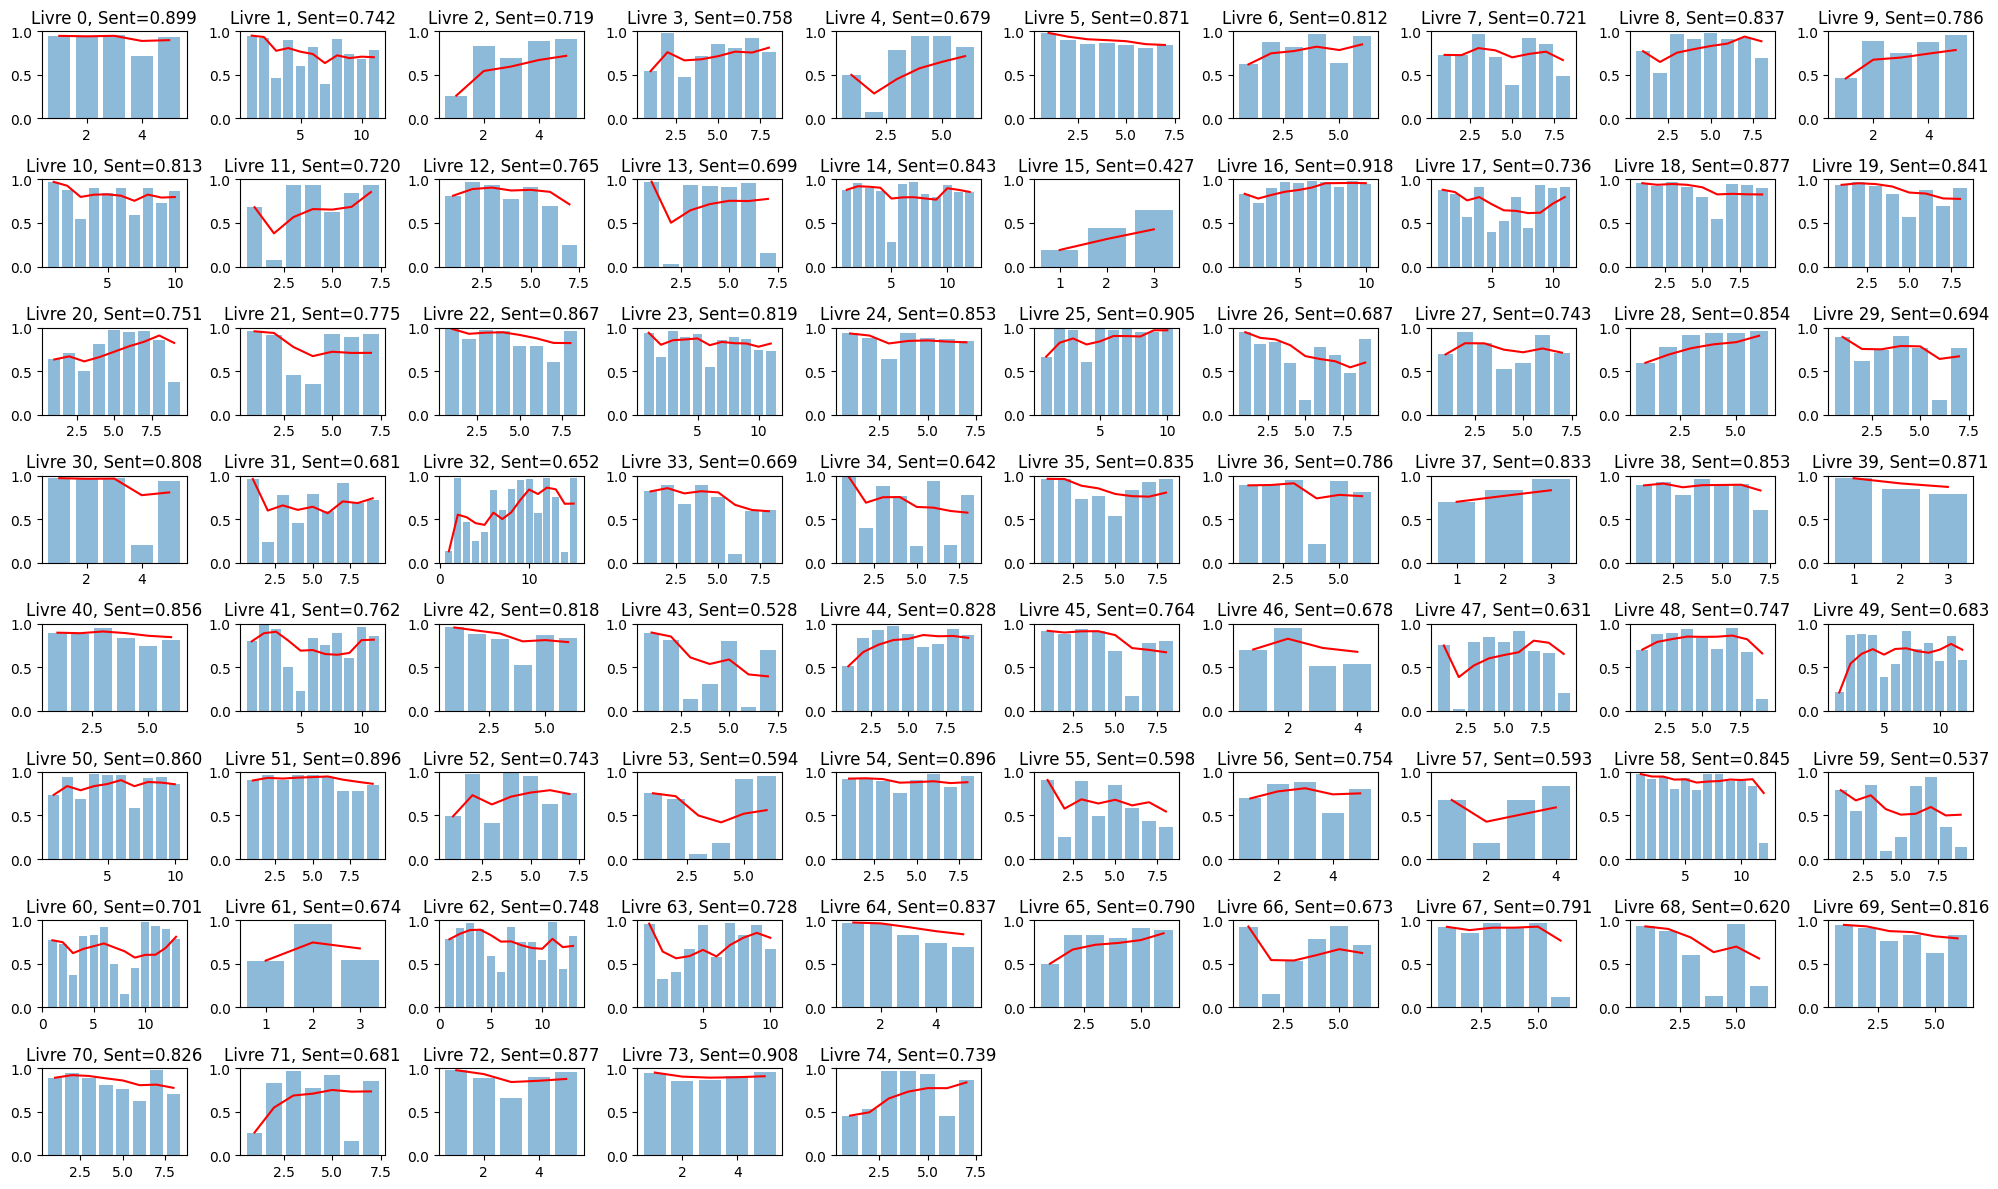

In [143]:
window_size = 5

nx_grid = int(np.sqrt(len(corpus_sentiments)))
ny_grid= int(np.ceil(len(corpus_sentiments) / nx_grid))

plt.rcParams['figure.figsize'] = [ny_grid*2, nx_grid*1.5]

fig = plt.figure()

grid_layout = GridSpec(nx_grid, ny_grid)

total_sent, total_part = 0, 0

for i, file_sentiments in enumerate(corpus_sentiments):
  mov_avg_df = pd.Series(file_sentiments).rolling(window_size, min_periods=1)
  mov_avg = mov_avg_df.mean().to_list()
  x_range = list(range(1, len(file_sentiments) + 1))
  ax = fig.add_subplot(grid_layout[i])
  ax.bar(x_range, file_sentiments, alpha=0.5)
  ax.plot(x_range, mov_avg, color="red")
  ax.set_ylim([0, 1])
  ax.set_title(f"Livre {i}, Sent={np.mean(file_sentiments):.3f}")
  total_sent += np.sum(file_sentiments)
  total_part += len(file_sentiments)

grid_layout.tight_layout(fig)

print(f'Sentiment moyen total = {total_sent/total_part:.3f}')


---
---
